# Viscosity Estimation from Pressure Signals
This script is used to analyze the effect of the parasite and unkown hydraulic capacitance and resistance that might be present in the proposed microfluidic viscometer, as well as to perform a comparative analysis of the different parameters' identification algorithms studied in this research.

The analysis must be configured for a number of sample inputs per signal (500, 1000 or 1500 points). Other configuration parameters are the number of simulations to run for each case in the sensitivity analysis or for each pattern in the benchmarking comparison. Note that, in order to reproduce the benchmark, this notebook must be launched three times (for 500, 1000 and 1500 input points respectively), setting the save_data variable to True.

The content of this notebook is the following:
- Assignation of values for all the elements of the circuits and their uncertainty ranges.
- Definition of all the equations involved in the analysis.
- Definition of estimation algorithms / load of estimation models.
- Sensitivity analysis for parasite terms.
- Benchmark generation for identification algorithms.


In [1]:
import yaml
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

import pywt

from scipy import signal
from scipy.integrate import solve_ivp
from scipy.stats import norm as norm_dist
from scipy import interpolate

import pysindy as psdy

from nfoursid.nfoursid import NFourSID as nfsid

from sysidentpy.model_structure_selection import FROLS as sipFROLS
from sysidentpy.basis_function import Polynomial as sipPoly

import tensorflow as tf
import keras

In [2]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Analysis Configuration

In [3]:
t_points = 1500 # Samples per signal (Only 500, 1000, 1500 are valid)
N = 50 # Number of simulations per case
N_sens = 150
save_data = True
sens_analysis=True

## 1. Elements of the circuit
The simulated circuit is showing here:

*Insert a diagram of the circuit*

Each dictionary holds the required values to define the associated element of the circuit. Within the dictionary there is a list called `"e_sources"`, or error sources. This list will contain all the parameters to be randomly modified in the Monte Carlo analysis. To do so, the parameter must have an associated parameter `_e`, which defined the absolute error associated to the parameter.

For example, if the diameter, `D`, of the first resistance, `R0`, must be analyzed, it must have an associated parameter `D_e`, defining the absolute uncertainty of that parameter. Also, `D` must be then included in the list `e_sources` of `R0`.

**Note**: It is important to respect the nomenclature in the dictionary of parameters. If it is a resistive element, it must start by `R`. If it is capacitive, `C`. After the identificative number, use a low bar, `_`, for the second part of the name (e.g. `R0_params`).

In [4]:
# Input resistance
elements = {
    "R0_params": {
        "D": 100e-6,
        "L": 1.0e-2,
        "e_sources": [],
        "e": {
            "D_e": 50e-6,
            "L_e": 1e-3
        }
    },

    # First RC Branch
    "R1_params": {
        "D": 100e-6,
        "L": 10e-2,
        "e_sources": [],
        "e": {
            "D_e": 15e-6,
            "L_e": 1e-3
        }
    },
    "C1_params": {
        "D": 2e-3,
        "L": 1.0e-2,
        "E": 10e6,
        "t": 0.75e-3,
        "beta": 2.5e9,
        "e_sources": [],
        "e": {
            "D_e": 0.0,
            "L_e": 0.5e-2
        }
    },

    # Second RC branch
    "R2_params": {
        "D": 100e-6,
        "L": 10e-2,
        "e_sources": [],
        "e": {
            "D_e": 15e-6,
            "L_e": 1e-3
        }
    },
    "C2_params": {
        "D": 2.0e-3,
        "L": 20.0e-2,
        "E": 10.0e6,
        "t": 0.75e-3,
        "beta": 2.5e9,
        "e_sources": [],
        "e": {
            "D_e": 5e-4,
            "L_e": 1e-3
        }
    },
}

In [5]:
# Use the above dictionaries to define the ranges
ranges_dict = {}
for ky, element in elements.items():
    ranges_dict[ky] = {}
    for param in set(element.keys())-set(["e_sources", "e"]):
        if param in element["e_sources"]:
            ranges_dict[ky][param] = (element[param] - element["e"][param+"_e"],
                                      element[param] + element["e"][param+"_e"])
        else:
            ranges_dict[ky][param] = (element[param], element[param])

print(ranges_dict)

{'R0_params': {'D': (0.0001, 0.0001), 'L': (0.01, 0.01)}, 'R1_params': {'D': (0.0001, 0.0001), 'L': (0.1, 0.1)}, 'C1_params': {'L': (0.01, 0.01), 'D': (0.002, 0.002), 't': (0.00075, 0.00075), 'beta': (2500000000.0, 2500000000.0), 'E': (10000000.0, 10000000.0)}, 'R2_params': {'D': (0.0001, 0.0001), 'L': (0.1, 0.1)}, 'C2_params': {'L': (0.2, 0.2), 'D': (0.002, 0.002), 't': (0.00075, 0.00075), 'beta': (2500000000.0, 2500000000.0), 'E': (10000000.0, 10000000.0)}}


## 2. Equations

### Input Signals

In [6]:
class step_signal:
    def __init__(self, A=1.0, k=1.0, offset=0.0) -> None:
        self.__name__ = "step_signal"
        self.A = A
        self.k = k
        self.offset = offset

    def __call__(self, t):
        res = np.sin(self.k*t*np.pi)
        return self.A if res > 0.0 else self.offset

class sinusoidal_signal:
    def __init__(self, A=1.0, k=1.0, offset=0.0) -> None:
        self.__name__ = "sinusoidal_signal"
        self.A = A
        self.k = k
        self.offset = offset
        
    def __call__(self, t,):
        return self.A*(np.sin(self.k*t*np.pi)+1)/2 + self.offset

class triangular_signal:
    def __init__(self, A=1.0, k=0.5, offset=0.0) -> None:
        self.__name__ = "triangular_signal"
        self.A = A
        self.k = k
        self.offset = offset
        
    def __call__(self, t):
        return self.A*(signal.sawtooth(self.k*t*2*np.pi, 0.5)+1.0) / 2 \
            + self.offset

class db5_signal:
    def __init__(self, th_psi=1e-3, A=1.0, k=1.0, offset=0.0) -> None:
        self.__name__ = "db5_signal"
        self.A = A
        self.k = k
        self.offset = offset
        self.wavelet = pywt.Wavelet("db5")
        phi, psi, x = self.wavelet.wavefun(level=4)
        # Remove silent space off signal
        for idx in range(len(psi)): # From the beginning
            if np.abs(psi[idx]) > th_psi:
                fist_i = idx 
                break
        for idx in range(len(psi)-1, 0, -1): # From the end
            if np.abs(psi[idx]) > th_psi:
                last_i = idx 
                break
        self.psi = psi[fist_i:last_i]
        self.t = x[fist_i:last_i]
        self.kT = self.t[-1] - self.t[0] # Func Period
        # Interpolation function
        self.db5_fn = interpolate.interp1d(self.t, self.psi)

    def __call__(self, t):
        # Ensure that t is within period time
        t_periodic = t*float(self.k)*np.pi*2.5
        while t_periodic < self.t[0]:
            t_periodic += self.kT
        while t_periodic > self.t[-1]:
            t_periodic -= self.kT
        # Call the interpolation function
        return float(self.A)*(self.db5_fn(t_periodic)+1)/2 + self.offset

### Physical Equations

In [7]:
class calc_water_viscosity:
    """
    Calculates the viscosity at some temperature, in Kelvin.

    This is a functor, so it must first be declared (changing the parameters if
    needed), and, after that, it can be called as any other function.
    """
    def __init__(self, A=2.414e-5, B=247.8, C=140):
        self.A = A
        self.B = B
        self.C = C
    def __call__(self, temp_K):
        return self.A * 10 ** (self.B / (temp_K - self.C))

def calc_cil_resistance(D, L, visc):
    """
    Calculates the hydraulic resistance for a cylindrical tube,
    for a given viscosity.
    """
    return 8*visc*L / (np.pi*((D/2)**4))

def calc_cil_capacitance(D, L, beta, E, t):
    """
    Calculates the theoretical capacitance of a cylindrical tube.
    """
    # Beta := Bulk Modulus of Water
    V0 = np.pi*(D/2)**2 * L
    return (V0 / beta)*( 1 + ((beta*D)/(E*t)) )

def circuit_dyn_eqs(t, dP, args): # R0, R1, R2, C1, C2, Pin
    """
    Calcualtes the differential values of pressure drop over the
    two RC branches of the circuit.
    """
    P1, P2 = dP # Integration of previous dP1, dP2
    Rp = args["R0"]
    R1 = args["R1"]
    R2 = args["R2"]
    Cp = args["C1"]
    C2 = args["C2"] 
    # Pin = args["Pin"]
    Pin = args["Pin"](t)

    dP1 = ((Pin - P1)/(Rp * Cp)) - ((P1 - P2) / (R1 * Cp))
    dP2 = ((P1 - P2)/(R1 * C2))- ((P2) / (R2 * C2))
    return [dP1, dP2]


## 3. Estimation Algorithms
There are six compared viscosity estimation algorithms: two based on classical techniques (N4SID and FROLS), and four based on deep learning techniques. Within the deep learning models, one is based on Convolutional Neural Networks (CNN), and the other is based on Long-Short Term Memory (LSTM) networks. The two remaining deep learning models are the quantized versions of the CNN and LSTM based models. This is done in this way such that classical techniques, which are easily implemented as embedded software, can be benchmarked under the conditions that the deep learning techniques would have as embedded software. 

- One observed limitation for SINDy is its dependence on the data points. If it is small, the quality of the discovered models (and the coefficients) can be very poor when compared with other techniques.

### 3.1 Classical-ish Algorithms

In [ ]:
def estimate_visc(t, P2_t, R2, C2, visc):
    """
    Estimates the viscosity from an step response of the target 
    microfluidic RC circuit. It assumes that there is not noise.

    The viscosity is asked as argument because R2 is assumed to 
    contain the viscosity. 
    """
    P_ss = P2_t[-1]
    if np.abs(P2_t[-1]-P2_t[-2]) > np.abs(0.02*P2_t[-1]):
        print("W: steady state value was not steady calculating visc.")
    P_tau = 0.632 * P_ss
    # Get closest time, t
    tau = t[ np.argmin(np.abs(np.subtract(P2_t, P_tau))) ]

    Rg = R2 / visc
    return tau / (Rg*C2)

class estimate_visc_sindy:
    # Not used
    def __init__(self) -> None:
        self.model = psdy.SINDy()

    def __call__(self, t, P1_t, P2_t):
        self.model.fit(P2_t, u=P1_t, t=t) # t[1]-t[0]
        # Get tau as the mean estimated from both variables
        # Model: dP2/dt = tau_a*P1 - tau_b*P2 -> tau = (tau_a+tau_b)/2
        return 1/np.mean(np.abs(self.model.coefficients()[0][1:3]))

class estimate_visc_n4sid:
    def __init__(self) -> None:
        self.ident = nfsid(
            pd.DataFrame(), 
            output_columns=[]
        )
        self.order = 1

    def __call__(self, t, P1_t, P2_t):
        self.ident.u_array = np.reshape(P1_t, [np.shape(P1_t)[0], 1])
        self.ident.u_dim = np.shape(self.ident.u_array)[1]
        self.ident.y_array = np.reshape(P2_t, [np.shape(P2_t)[0], 1])
        self.ident.y_dim = np.shape(self.ident.y_array)[1]

        self.ident.subspace_identification()

        ORDER_OF_MODEL_TO_FIT = 1
        identified_sys, cov_matrix = \
            self.ident.system_identification( rank=self.order )
        
        # From discrete to continuous
        incT = t[1]-t[0]
        tau1 = incT / (1-identified_sys.a[0][0])
        # tau2 = incT / identified_sys.d[0][0]
        return tau1

from sysidentpy.parameter_estimation import TotalLeastSquares as estimator

class estimate_visc_frols:
    def __init__(self) -> None:
        self.model = sipFROLS(
            order_selection=False,
            n_info_values=100,
            n_terms=2,
            ylag=1,
            xlag=1,
            info_criteria='aic',
            estimator=estimator(),
            basis_function=sipPoly(degree=1),
        )

    def __call__(self, t, P1_t, P2_t):
        x = np.reshape(P1_t, [np.shape(P1_t)[0], 1])
        y = np.reshape(P2_t, [np.shape(P2_t)[0], 1])

        self.model.fit(X=x, y=y)

        # Debugging
        # The ARMAX model is discrete, it's necessary to recover
        # the time constant, tau, from it.
        # Variable: 1001 := y{k-1}, 1002 := y{k-2}, 2002 := x{k-2}
        # print(self.model.final_model)
        # print(self.model.theta)
        # print(t[1]-t[0])
        
        incT = t[1]-t[0]
        idx = list(self.model.final_model).index([1001]) if \
            [1001] in list(self.model.final_model) else 0
        
        tau = -incT / np.log(np.abs(self.model.theta[idx][0]))
        return tau

### 3.2 DL Estimation Models

In [9]:
class estimate_visc_ann:
    def __init__(self, model_path, model_cfg) -> None:
        # Load the model
        self.model_path = model_path
        self.model = tf.keras.models.load_model(model_path)

        # Valid for Keras 3.5 and TensorFlow 2.17
        # self.model = tf.keras.layers.TFSMLayer(model_path, 
        #                                        call_endpoint="serving_default")

        # Load the configuration of the model
        with open(model_cfg) as cfg_file:
            self.cfg = yaml.safe_load(cfg_file)
        print("ANN Model with values:")
        print("X Maxs: {}, Mins: {}".format(self.cfg["max_X"], self.cfg["min_X"]))
        print("Y Maxs: {}, Mins: {}".format(self.cfg["max_Y"], self.cfg["min_Y"]))
        print("Norm X range: {}, offset: {}".format(self.cfg["norm_X_range"], self.cfg["norm_X_offset"]))
        print("Norm Y range: {}, offset: {}".format(self.cfg["norm_Y_range"], self.cfg["norm_Y_offset"]))

    def _format_in(self, P1_t, P2_t, t):
        # Join the signals and given them 1-bach format
        X = np.array([P1_t, P2_t, t])
        X = np.transpose(X).reshape(1, -1, np.shape(X)[0])
        # Automatic input normalization
        return np.multiply(np.divide(X, np.subtract(self.cfg["max_X"], self.cfg["min_X"])),
                           self.cfg["norm_X_range"]) + self.cfg["norm_X_offset"]

    def _undo_norm(self, y):
        return ((y - self.cfg["norm_Y_offset"]) / self.cfg["norm_Y_range"]) * \
            (self.cfg["max_Y"] - self.cfg["min_Y"])

    def __call__(self, t, P1_t, P2_t):
        """
        The model is trained to estimate the param alpha = (incT) / (Rg*C*visc)

        Thus, it returns the parameter beta = incT / alpha, which is the param
        independent of sampling time, from which the viscosity can be calculated
        using the values of the circuit.
        """
        # Format the input
        X = self._format_in(P1_t, P2_t, t)
        # Forward the model
        y = self.model.predict(X, verbose=None)
        # # Valid for Keras 3.5 and TensorFlow 2.17
        # y = self.model(X)["output_0"]

        return self._undo_norm( tf.squeeze(y).numpy() )


class estimate_visc_qann:
    """
    """
    def __init__(self, model_path, model_cfg) -> None:
        """
        For now, only automatically quantized inputs/outputs are here allowed.
        """
        # Load the model
        self.interpreter = tf.lite.Interpreter(model_path=model_path)
        self.interpreter.allocate_tensors()
        self.input_details = self.interpreter.get_input_details()[0]
        print("Input: {}".format(self.input_details["dtype"]))
        self.output_details = self.interpreter.get_output_details()[0]
        print("Output: {}".format(self.output_details["dtype"]))
        self.output_buffer = 0.0
        if "cnn" in model_path:
            self.ann_type = "cnn"
        else: 
            self.ann_type = "lstm"

        # Load the configuration of the model
        with open(model_cfg) as cfg_file:
            self.cfg = yaml.safe_load(cfg_file)

    def _format_in(self, P1_t, P2_t, t):
        # Join the signals and given them 1-bach format
        X = np.array([P1_t, P2_t, t])
        X = np.transpose(X).reshape(1, -1, np.shape(X)[0])
        # Automatic input normalization
        X = np.multiply(np.divide(X, np.subtract(self.cfg["max_X"], self.cfg["min_X"])),
                        self.cfg["norm_X_range"]) + self.cfg["norm_X_offset"]
        return np.float32(X)

    def _undo_norm(self, y):
        return ((y - self.cfg["norm_Y_offset"]) / self.cfg["norm_Y_range"]) \
                * (self.cfg["max_Y"]-self.cfg["min_Y"])

    def __call__(self, t, P1_t, P2_t):
        """
        The model is trained to estimate the param alpha = (incT) / (Rg*C*visc)

        Thus, it returns the parameter beta = incT / alpha, which is the param
        independent of sampling time, from which the viscosity can be calculated
        using the values of the circuit.
        """
        # Format the input
        X = self._format_in(P1_t, P2_t, t)
        # Forward the model
        self.interpreter.set_tensor(self.input_details["index"], X)
        self.interpreter.invoke()
        self.output_buffer = self.interpreter.get_tensor(self.output_details["index"])
        # Get the right output format
        return self._undo_norm( tf.squeeze(self.output_buffer).numpy() )


In [ ]:
lstm_model_path = "..\processing\models\cnn_lstm_{}pt.model".format(t_points)
lstm_model_cfg = "..\processing\models\cnn_lstm_{}pt.model\model_cfg.yaml".format(t_points)

cnn_model_path = "..\processing\models\cnn_{}pt.model".format(t_points)
cnn_model_cfg = "..\processing\models\cnn_{}pt.model\model_cfg.yaml".format(t_points)

qlstm_model_path = "..\processing\models\quantized\cnn_lstm_{}pt\cnn_lstm_{}pt.tflite".format(t_points, t_points)
qlstm_model_cfg = "..\processing\models\cnn_lstm_{}pt.model\model_cfg.yaml".format(t_points)

qcnn_model_path = "..\processing\models\quantized\cnn_{}pt\cnn_{}pt.tflite".format(t_points, t_points)
qcnn_model_cfg = "..\processing\models\cnn_{}pt.model\model_cfg.yaml".format(t_points)


# Encapsulate all algorithms inside a dictionary
alg_dict = {
    "N4SID": estimate_visc_n4sid(),
    "FROLS": estimate_visc_frols(),
    "LSTM": estimate_visc_ann(lstm_model_path, lstm_model_cfg),
    "CNN": estimate_visc_ann(cnn_model_path, cnn_model_cfg),
    "qLSTM": estimate_visc_qann(qlstm_model_path, qlstm_model_cfg),
    "qCNN": estimate_visc_qann(qcnn_model_path, qcnn_model_cfg)
}




ANN Model with values:
X Maxs: [1.15, 1.15, 360.0], Mins: [0.0, 0.0, 0.0]
Y Maxs: 8.5, Mins: 1.0
Norm X range: [1.5, 1.5, 1.5], offset: [-0.5, -0.5, -0.5]
Norm Y range: 1.5, offset: -0.5
ANN Model with values:
X Maxs: [1.15, 1.15, 360.0], Mins: [0.0, 0.0, 0.0]
Y Maxs: 8.5, Mins: 1.0
Norm X range: [1.5, 1.5, 1.5], offset: [-0.5, -0.5, -0.5]
Norm Y range: 1.5, offset: -0.5
Input: <class 'numpy.float32'>
Output: <class 'numpy.float32'>
Input: <class 'numpy.float32'>
Output: <class 'numpy.float32'>


## 4. Sensibility Analysis - Parasite Terms
For each of the element of the circuit, there are some defined ranges of values that the element can take. The objective of this analysis is to study how much will affect each of the variations to the output estimation of viscosity.

The analysis is performed by running a large number of simulations (proportional to the complexity of the system and the number of uncertain variables), propagating each variation to an objective value. For example, if the uncertainty source is one dimension of a resistance, the resistance will be calculated for each simulation with a dimension randomly chosen within the defined range. For each simulation, the viscosity will be calculated. The variation at viscosity estimation accuracy is then compared with the variation of the input parameter, producing a sensibility estimation between both of them.

Each of the estimation algorithms is tested with varying paratise terms such that their sensibility to unknown parasite effects can be determined.

In [ ]:
if sens_analysis:
    temp_C = 28.65 # In Celsius
    temp_K = temp_C + 273.15
    visc_calc = calc_water_viscosity()
    visc = visc_calc(temp_K)
    visc = 1.5e-3

    # Input signal ranges
    A_range = (0.6, 1.0)
    offset_range = (0.0, 0.3)
    k_range = (0.015, 0.03)

    # Parameters uncertainties
    sets = {"R0": {"L": [0.5e-2, 1.0e-2, 2.5e-2, 5.0e-2, 7.5e-2, 0.0, 0.0, 0.0, 0.0, 0.0]}, 
            "C1": {"L": [0.0, 0.0, 0.0, 0.0, 0.0, 0.5e-2, 1.0e-2, 2.5e-2, 5.0e-2, 7.5e-2]}}
    n_sets = 10

    results = {}
    for ky in ranges_dict.keys():
        results[ky.split("_")[0]] = []
    for alg_name in alg_dict.keys():
        results[alg_name+"_est_visc"] = []
        results[alg_name+"_tau1"] = []
        results[alg_name+"_tau2"] = []
        for elem in sets.keys():
            for param in sets[elem].keys():
                results["{}_{}_unc".format(elem, param)] = []

    for set_i in range(n_sets):
        for n in tqdm(range(N_sens)): # For progress bar
            # Signal randomization
            # Get the values of the parameters
            A = np.random.uniform(A_range[0], A_range[1])
            # Control offset range based on A s.t. values remain below 1.0
            offset = np.random.uniform(offset_range[0], offset_range[1])
            # Reset it if there is no space for offsets
            if offset > (1.0 - A): offset = 0.0
            k = np.random.uniform(k_range[0], k_range[1])
            sim_params = {
                "Pin":step_signal(A=A, k=k, offset=offset)
            }

            for ky, element_ranges in ranges_dict.items():
                # Extract the random values for the parameters
                args = {}
                for param, param_ranges in element_ranges.items():
                    if (ky.split("_")[0] in sets) and (param in sets[ky.split("_")[0]]):
                        # Uncertainty range variation for this iteration
                        vals = [param_ranges[0],
                                param_ranges[1]+sets[ky.split("_")[0]][param][set_i]]
                        args[param] = np.max([0.0, 
                                            np.random.uniform(*vals)])
                    else:
                        args[param] = np.max([0.0, np.random.uniform(*param_ranges)])
                # Resistance
                if ky[0] == "R":
                    sim_params[ky.split("_")[0]] = calc_cil_resistance(**args, visc=visc)
                # Capacitance
                elif ky[0] == "C":
                    sim_params[ky.split("_")[0]] = calc_cil_capacitance(**args)
                else: 
                    print("Error: element {} not recognized".format(ky))
                    exit()
                
            # Perform the simulation
            t_sim = np.random.uniform(50, 360)
            sol = solve_ivp(circuit_dyn_eqs, [0, t_sim], [0, 0], args=(sim_params,), 
                            dense_output=True)
            
            # Save the results
            t = np.linspace(0, t_sim, t_points)
            P1_t = sol.sol(t)[0]
            P2_t = sol.sol(t)[1]

            # If you want to print some curves, don't make N very large
            # print("For viscosity: {}".format(visc))
            # plt.plot(t, P2_t)
            # plt.plot(t, P1_t)
            # plt.grid(True)
            # plt.show()

            for alg_i, alg_name in enumerate(alg_dict.keys()):
                # Estimate viscosity
                R1g = sim_params["R1"] / visc
                R2g = sim_params["R2"] / visc
                tau1 = ((sim_params["R1"]*sim_params["R2"]*sim_params["C2"])/
                        (sim_params["R1"]+sim_params["R2"])) # Theoretical value
                tau2 = alg_dict[alg_name](t, np.array(P1_t), np.array(P2_t))
                est_visc = tau2 * ((R1g+R2g)/(R1g*R2g*sim_params["C2"])) # Estimate

                # Save the results
                results[alg_name+"_tau1"].append(tau1)
                results[alg_name+"_tau2"].append(tau2)
                results[alg_name+"_est_visc"].append(est_visc)
                if alg_i == 0:
                    # Do this only for the first algorithm
                    for elem in sets.keys():
                        for param in sets[elem].keys(): 
                            results["{}_{}_unc".\
                                    format(elem, param)].append(sets[elem][param][set_i])

            # Update the results dict
            for ky in ranges_dict.keys():
                results[ky.split("_")[0]].append( sim_params[ky.split("_")[0]] )

    res_df = pd.DataFrame.from_dict(results)

100%|██████████| 150/150 [00:31<00:00,  4.74it/s]


### Parasite Effect on Algorithm Estimates
The calculated stats are the following:
- Mean $C_p$ to mean $C$ ratio: Percentage that mean $C_p$ suposses to mean $C$. This is, how big is (average) parasite capacitance, $C_p$, compared to the main measurement capacitance, $C$.
- $C_p$ approx. perc. deviation: Percentage that indicates how much $C$ varies from its mean value along the sensitivity analysis.
- Est. viscosity approx. perc. deviation: How much the estimated viscosity varies from its mean value when varying the input values. This indicates how sensible it is to the change in the, in this case, parasite capacitance.
- Est. viscosity MAE: Mean Absolute Error of the viscosity estimation with respect to the real value of viscosity.

Note: in some parts of the code, $C_p$ is named $C_1$, and $C$ is named $C_2$.

### How to interpret the values?
If a high variation of the parasite capacitance, $C_p$, produces a small variation of the estimated viscosity deviation, it means that the sensibility of the calculation is low. This is, the parasite capacitance doesn't affect much to its **precision**. To complete the analysis, it must be observed if it affects to the **accuracy** of the estimation. For example, it could induce an offset that is constant (precision wouldn't be affected), but makes the mean value of the estimate deviate from the real value. This is done by calculating the MAE, which should also remain low for "big" parasite capacitances.

It can be observed that the effect of the parasite capacitance, $C_p$, alone is low. This is because the problems comes with the time response of the parasite capacitance, and not only the capacitance itself. This means that $R_0$ is also important in this analysis. If this resistance is high, $C_p$ takes more time to fill up, affecting negatively to the estimate of viscosity.

The same observations are obtained for the parasite resistance, $R_p$. The analysis cover these two elements to understand the robustness of the algorithms.

Real viscosity: 1.10000e-03
Sensibility Analysis:
                  means_set0      std_set0    means_set1      std_set1  \
R0              5.623570e+12  6.459339e+11  6.657522e+12  1.275995e+12   
R1              4.481803e+13  7.838673e-03  4.481803e+13  7.838673e-03   
C1              8.390147e-15  0.000000e+00  8.390147e-15  0.000000e+00   
R2              4.481803e+13  7.838673e-03  4.481803e+13  7.838673e-03   
C2              1.678029e-13  0.000000e+00  1.678029e-13  0.000000e+00   
N4SID_est_visc  1.119019e-03  8.246812e-06  1.119742e-03  8.641456e-06   
N4SID_tau1      3.760299e+00  4.455770e-16  3.760299e+00  4.455770e-16   
N4SID_tau2      3.825313e+00  2.819134e-02  3.827786e+00  2.954041e-02   
R0_L_unc        5.000000e-03  0.000000e+00  1.000000e-02  0.000000e+00   
C1_L_unc        0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
FROLS_est_visc  1.091564e-03  3.094996e-06  1.102246e-03  8.327523e-05   
FROLS_tau1      3.760299e+00  4.455770e-16  3.760299e+00  4.45

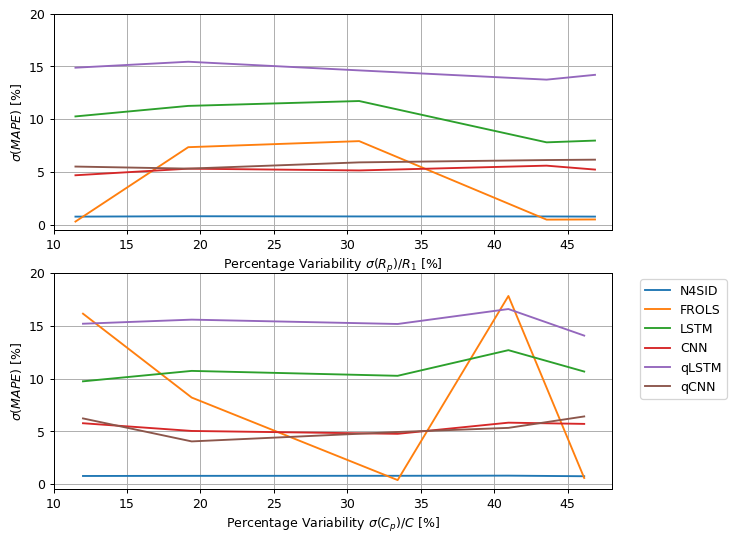

In [36]:
if sens_analysis:
    print("Real viscosity: {:.5e}".format(visc))

    sens_df = pd.DataFrame()

    masks = []
    for set_i in range(n_sets):
        mask_i = None
        for elem in sets.keys():
            for param in sets[elem].keys():
                if mask_i is None:
                    mask_i = (res_df["{}_{}_unc".format(elem, param)] == sets[elem][param][set_i])
                else:
                    mask_i = mask_i & (res_df["{}_{}_unc".format(elem, param)] == sets[elem][param][set_i])
        masks.append( mask_i )
        sens_df["means_set{}".format(set_i)] = \
            res_df.loc[ mask_i ].mean()
        sens_df["std_set{}".format(set_i)] = \
            res_df.loc[ mask_i ].std()

    print("Sensibility Analysis:")
    print(sens_df)

    Rp_ratio_means = []
    Rp_ratio_var = []
    Cp_ratio_means = []
    Cp_ratio_var = []
    mapes = {alg: [] for alg in alg_dict.keys()}
    stds = {alg: [] for alg in alg_dict.keys()}
    sensR = {alg: [] for alg in alg_dict.keys()}
    sensC = {alg: [] for alg in alg_dict.keys()}

    for set_i in range(n_sets):
        # Inputs variations
        print("\nSet {}".format(set_i))
        Rp_ratio_means.append((1-np.abs((res_df.loc[masks[set_i]]["R0"].mean() - res_df.loc[masks[set_i]]["R1"].mean()) \
                / res_df.loc[masks[set_i]]["R1"].mean())) * 100 )
        Rp_ratio_var.append( res_df.loc[masks[set_i]]["R0"].std() / res_df.loc[masks[set_i]]["R0"].mean() * 100 )
        Cp_ratio_means.append( 
            (1-np.abs((res_df.loc[masks[set_i]]["C1"].mean() - res_df.loc[masks[set_i]]["C2"].mean()) \
                / res_df.loc[masks[set_i]]["C2"].mean())) * 100 )
        Cp_ratio_var.append( res_df.loc[masks[set_i]]["C1"].std() / res_df.loc[masks[set_i]]["C1"].mean() * 100 )
        
        print("Mean R0 to mean R1 ratio: {:.3f} %".format(Rp_ratio_means[-1]))
        print("R0 approx. perc. deviation: {:.3f} %".format(Rp_ratio_var[-1]))
        print("Mean C1 to mean C2 ratio: {:.3f} %".format(Cp_ratio_means[-1]))
        print("C1 approx. perc. deviation: {:.3f} %".format(Cp_ratio_var[-1]))

        for alg_name in alg_dict.keys():
            print("Algorithm: {}".format(alg_name))
            mapes[alg_name].append(np.abs((visc - res_df.loc[masks[set_i]][alg_name+"_est_visc"].mean()) \
                                        / visc) * 100)
            # stds[alg_name].append((res_df.loc[masks[set_i]][alg_name+"_est_visc"].std() / \
            #         res_df.loc[masks[set_i]][alg_name+"_est_visc"].mean()) * 100)
            stds[alg_name].append(np.abs((visc - res_df.loc[masks[set_i]][alg_name+"_est_visc"]) \
                            / visc).std() * 100)
            print("[Precision] Est. viscosity approx. perc. deviation: {:.3f} %".format(
                mapes[alg_name][-1]
            ))
            # Mean estimation difference to real viscosity
            print("[Accuracy]  Est. viscosity MAPE: {:.3f} %".format(
                stds[alg_name][-1]
            ))
            sensR[alg_name].append(mapes[alg_name][-1] / Rp_ratio_var[-1])
            sensC[alg_name].append(mapes[alg_name][-1] / Cp_ratio_var[-1])

    # Better than this: plot 3d whre x=value of r, y=value of c, z=mape [one plot by algorithm]
    plt.figure(figsize=(8, 7), dpi=90)
    for alg_name in alg_dict.keys():
        plt.subplot(2,1,1)
        plt.plot(Rp_ratio_var[:5], stds[alg_name][:5], label=alg_name)
        plt.grid(True)
        plt.xlabel("Percentage Variability $\sigma(R_{p}) / R_1$ [%]")
        plt.ylabel("$\sigma (MAPE)$ [%]")
        ax = plt.gca()
        ax.set_ylim([-0.5, 20])
        ax.set_xlim([10, 48])

        plt.subplot(2,1,2)
        plt.plot(Cp_ratio_var[5:], stds[alg_name][5:], label=alg_name)
        plt.grid(True)
        # plt.legend(loc="center left")
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
        plt.xlabel("Percentage Variability $\sigma(C_{p}) / C$ [%]")
        plt.ylabel("$\sigma (MAPE)$ [%]")
        ax = plt.gca()
        ax.set_ylim([-0.5, 20])
        ax.set_xlim([10, 48])
    plt.show()

## 5. Algorithms Performance Analysis by Input Signal

In this section, the estimation algorithms are tested with different input: step, sinusoidal, triangular and daubechies (heartbeat) signals, with and without injected noise. The objective is to test their performance in many different situations so a benchmark can be produced to understand the advantages of each one depending on the situation.

In this analysis, the **viscosity is randomly changed** within a defined range.

In [ ]:
sim_conditions = [
    {"sig": step_signal, "noise": 0.0},
    {"sig": step_signal, "noise": 0.025},
    {"sig": sinusoidal_signal, "noise": 0.0},
    {"sig": sinusoidal_signal, "noise": 0.025},
    {"sig": triangular_signal, "noise": 0.0},
    {"sig": triangular_signal, "noise": 0.025},
    {"sig": db5_signal, "noise": 0.0},
    {"sig": db5_signal, "noise": 0.025}
]

In [ ]:
visc_range = (0.79e-3, 2.2e-3)
A_range = (0.6, 1.0)
offset_range = (0.0, 0.3)
k_range = (0.015, 0.03)

res_sig_dict = {
    "visc": [],
    "tau": [],
    "tau_th": [],
    "est_visc": [],
    "est_acc": [],
    "algorithm": [],
    "signal": [],
    "noise": [],
    "time": []
}

for sim_i, sim_cond in enumerate(sim_conditions):
    print("Simulating with conditions set {} / {}. Signal: {}".format(
        sim_i+1, len(sim_conditions), sim_cond["sig"].__name__))
    for n in tqdm(range(N)): # For progress bar
        # Get the values of the parameters
        A = np.random.uniform(A_range[0], A_range[1])
        # Control offset range based on A s.t. values remain below 1.0
        offset = np.random.uniform(offset_range[0], offset_range[1])
        # Reset it if there is no space for offsets
        if offset > (1.0 - A): offset = 0.0
        k = np.random.uniform(k_range[0], k_range[1])
        sim_params = {
            "Pin": sim_cond["sig"](A=A, k=k, offset=offset)
        }
        # Get a random value of viscosity within range
        visc = np.max([0.0, np.random.uniform(*visc_range)])
        # visc = 2.19e-3 # Just if you want to simulate specific visc

        for ky, element_ranges in ranges_dict.items():
            # Extract the random values for the parameters
            args = {}
            for param, param_ranges in element_ranges.items():
                # We just take the bigger element. No random
                args[param] = np.max([0.0, param_ranges[1]])
            # Resistance
            if ky[0] == "R":
                sim_params[ky.split("_")[0]] = calc_cil_resistance(**args, visc=visc)
            # Capacitance
            elif ky[0] == "C":
                sim_params[ky.split("_")[0]] = calc_cil_capacitance(**args)
            else: 
                print("Error: element {} not recognized".format(ky))
                exit()
            
        # Perform the simulation
        t_sim = np.random.uniform(50, 360)
        sol = solve_ivp(circuit_dyn_eqs, [0, t_sim], [0, 0], args=(sim_params,), 
                        dense_output=True)
        
        # Save the results
        t = np.linspace(0, t_sim, t_points)
        P1_t = sol.sol(t)[0]
        P2_t = sol.sol(t)[1]

        # Add measurement noise
        if sim_cond["noise"] > 0.0:
            N_dev = np.abs(np.random.normal(0.0, sim_cond["noise"]))
            P1_t += np.random.normal(0.0, N_dev, np.shape(P1_t))
            P2_t += np.random.normal(0.0, N_dev, np.shape(P2_t))

        # If you want to print some curves, don't make N very large
        # plt.plot(t, P2_t, "k")
        # plt.plot(t, P1_t, "k--")
        # plt.ylabel("Normalized Pressure [n.u.]")
        # plt.xlabel("Time [s]")
        # plt.grid(True)
        # plt.show()

        for alg_name in alg_dict.keys():
            # Estimate viscosity
            start = time.perf_counter_ns() # Alg. Execution Performance - Start

            R1g = sim_params["R1"] / visc
            R2g = sim_params["R2"] / visc
            tau2 = alg_dict[alg_name](t, P1_t, P2_t)
            # est_visc = tau2 / (R2g*sim_params["C2"]) # (R1g+R2g)
            tau1 = ((sim_params["R1"]*sim_params["R2"]*sim_params["C2"])/
                    (sim_params["R1"]+sim_params["R2"])) # Theoretical value
            est_visc = tau2 * ((R1g+R2g)/(R1g*R2g*sim_params["C2"]))

            end = time.perf_counter_ns() #  Alg. Execution Performance - Finish

            # Save the results
            res_sig_dict["visc"].append( visc )
            res_sig_dict["algorithm"].append( alg_name )
            res_sig_dict["est_visc"].append( est_visc )
            res_sig_dict["est_acc"].append( np.abs((visc - est_visc) / visc) * 100 )
            res_sig_dict["tau"].append( tau2 )
            res_sig_dict["tau_th"].append( tau1 )
            res_sig_dict["signal"].append( sim_cond["sig"].__name__ )
            res_sig_dict["noise"].append( sim_cond["noise"] )
            res_sig_dict["time"].append( float(end - start)/1e9 )

print("Done.")
res_sig_df = pd.DataFrame.from_dict(res_sig_dict)

### Input Signal Effect on Algorithm Estimates
In this section the performance of each algorithm is analyzed with different input signals, with and without noise injected. The objective is to benchmark their accuracy for many different conditions. 

In [ ]:
plot_distributions=False

# Get the accuracy by algorithm, for each type of input signal, with and without noise
analysis_dict = {
    "algorithm": [],
    "signal": [],
    "noise": [],
    "precision": [],
    "rel_error": [],
    "runtime": []
}
dists = {
    "params": [],
    "x": [],
    "y": []
}
for alg_name in alg_dict.keys():
    for sim_i, sim_cond in enumerate(sim_conditions):
        subset_df = res_sig_df.loc[
            (res_sig_df["algorithm"] == alg_name) &
            (res_sig_df["signal"] == sim_cond["sig"].__name__) & 
            (res_sig_df["noise"] == sim_cond["noise"])
        ]
        analysis_dict["algorithm"].append( alg_name )
        analysis_dict["signal"].append( sim_cond["sig"].__name__ )
        analysis_dict["noise"].append( sim_cond["noise"] )
        analysis_dict["rel_error"].append( min(100, subset_df["est_acc"].mean()) )
        analysis_dict["precision"].append( 
            subset_df["est_acc"].std()
         )
        analysis_dict["runtime"].append( subset_df["time"].mean() )

        if plot_distributions:
            # Fit distributions for visualization
            # Normal distribution
            dists["params"].append( norm_dist.fit( subset_df["est_acc"] ) )
            if ( np.max(subset_df["est_acc"]) - np.min(subset_df["est_acc"]) > 0.2):
                dists["x"].append( np.linspace(np.min(subset_df["est_acc"]), 
                                            min(np.max(subset_df["est_acc"]), 250), 
                                            100) )
            else:
                dists["x"].append(np.linspace(np.min(subset_df["est_acc"])-0.1, 
                                            np.max(subset_df["est_acc"])+0.1, 
                                            100))
            dists["y"].append( norm_dist.pdf(dists["x"][-1], *dists["params"][-1]) )
            # And plot them
            plt.plot(dists["x"][-1], dists["y"][-1])
            plt.hist(np.clip(subset_df["est_acc"], a_min=0, a_max=250), 
                    bins=25, density=True, alpha=0.3, color='b')
            plt.title( "RED. Alg.: " + alg_name +
                    ", Sig.: {}, Noise {}".format(sim_cond["sig"].__name__, 
                                                    sim_cond["noise"]) )
            plt.grid(True)
            plt.figure()

benchmark_df = pd.DataFrame(analysis_dict)
if save_data:
    benchmark_df.to_csv("../processing/benchmarks/synthetic_{}pt.csv".format(t_points), float_format='%.6e')
    res_sig_df.to_csv("../processing/benchmarks/raw/raw_data_synthetic_{}pt.csv".format(t_points), float_format='%.6e')
print(benchmark_df)

# Show
if plot_distributions: plt.show()

## 6. Validation with Experimental Data
In this section, the algorithms process experimental signals from the built prototype to test their accuracy with real data. The experimental data is composed of pressure signals gathered in experiments using the prototype with different input pressure patterns (step, sinusoidal, etc.) and fluids (water, isopropanol, ethanol 70%, etc.). Each signal has a reference viscosity value obtained from an accurate viscometer.

For the values of the elements of the experimental setup, it is also allowed to set a range for each dimension such that any uncertainty (e.g. from manufacturing process) can be inserted in the analysis like for the Monte Carlo analysis.

This validation dataset is used to benchmark each method's accuracy.

In [ ]:
experiment_folders = {
    "ethanol": "../processing/data/validation/Ethanol_70pc/processed_{}pt".format(t_points),
    # "IPA": "../processing/data/validation/IPA_100pc/processed_{}pt".format(t_points),
}

res_exp_dict = {
    "visc": [],
    "tau": [],
    "est_visc": [],
    "est_acc": [],
    "algorithm": [],
    "fluid": [],
    "runtime": []
}

for fluid in experiment_folders:
    # Load the values of the circuit elements
    with open(experiment_folders[fluid]+"/microfluidic_setup.yaml") as cfg_f:
        circuit_raw = yaml.safe_load(cfg_f)
    circuit, exp_params = {}, {}
    for ky, element in circuit_raw["elements"].items():
        circuit[ky] = {}
        for param in set(element.keys())-set(["e_sources", "e"]):
            if param in element["e_sources"]:
                circuit[ky][param] = (element[param] - element["e"][param+"_e"],
                                      element[param] + element["e"][param+"_e"])
            else:
                circuit[ky][param] = (element[param], element[param])

    # Load the experimental data (stored in different folders)
    X = np.load(experiment_folders[fluid]+"/X_samples.npy") / 2000.0 # Normalization
    Y = np.load(experiment_folders[fluid]+"/Y_samples.npy") #/ 1000.0 # Units
    # Also the sampling times!
    incT = np.load(experiment_folders[fluid]+"/incT_samples.npy")

    # Calibration Data
    # T= 25°C ;
    # mu = 0.890023e-3 [Pa.s] ;
    # R1: 3.7134e+16 [Pa.s/m3],      R1g: 3.7134e+16 [m-3] ;
    # R2: 3.7556e+16 [Pa.s/m3],      R2g: 3.7556e+16 [m-3] ;
    # C2: 2.566e-13 [m3/Pa]
    R1Cal = 3.305e+13
    R2cal = 3.3425e+13
    C2cal = 2.566e-13

    # Predict
    for idx in range(len(X)): # range(1):
        for alg_name in alg_dict.keys():
            
            # Get the theoretical values for reference
            for ky, element_ranges in circuit.items():
                # Extract the random values for the parameters
                args = {}
                for param, param_ranges in element_ranges.items():
                    args[param] = np.max([param_ranges[0], param_ranges[1]])
                # Resistance
                if ky[0] == "R":
                    exp_params[ky.split("_")[0]] = calc_cil_resistance(**args, visc=Y[idx])
                # Capacitance
                elif ky[0] == "C":
                    exp_params[ky.split("_")[0]] = calc_cil_capacitance(**args)
                else: 
                    print("Error: element {} not recognized".format(ky))
                    exit()
            
            # Calibrated Values
            R1g = 3.7134e+16
            R2g = 3.7556e+16
            C = 2.566e-13

            # Theoretical Values
            # R1g = exp_params["R1"] / Y[idx]
            # R2g = exp_params["R2"] / Y[idx]
            # C = exp_params["C2"]

            # Give some shape
            P1_t = np.transpose(X[idx])[0]
            P2_t = np.transpose(X[idx])[1]
            t = np.array([incT[idx]*i for i in range(len(P1_t))])

            # Time start
            start = time.perf_counter_ns()

            # Estimate viscosity
            tau2 = alg_dict[alg_name](t, P1_t, P2_t)
            # est_visc = tau2 / ((R1g+R2g)*C) # (R1g+R2g)
            est_visc = tau2 * ((R1g+R2g)/(R1g*R2g*C))

            # Time end
            end = time.perf_counter_ns()

            # Save the results
            res_exp_dict["visc"].append( Y[idx] )
            res_exp_dict["algorithm"].append( alg_name )
            res_exp_dict["est_visc"].append( est_visc )
            res_exp_dict["est_acc"].append( np.abs((Y[idx] - est_visc) / Y[idx]) * 100 )
            res_exp_dict["tau"].append( tau2 )
            res_exp_dict["fluid"].append( fluid )
            res_exp_dict["runtime"].append( (end - start)/1e9 )

exp_df = pd.DataFrame.from_dict( res_exp_dict )

### Verification for calibration values

In [ ]:
print("Calibration Values")
print("R1: {:.4e}, R1g: {:.4e}".format(R1Cal, R1g))
print("R2: {:.4e}, R2g: {:.4e}".format(R2cal, R2g))
print("C2: {:.4e}".format(C))
est_visc = tau2 * ((R1g+R2g)/(R1g*R2g*C))
print("Est. visc: {}".format(est_visc))

print("\nTheoretical Values")
print("R1: {:.4e}, R1g: {:.4e}".format(exp_params["R1"], exp_params["R1"] / Y[idx]))
print("R2: {:.4e}, R2g: {:.4e}".format(exp_params["R2"], exp_params["R2"] / Y[idx]))
print("C2: {:.4e}".format(exp_params["C2"]))
est_visc = tau2 * (((exp_params["R1"] / Y[idx])+(exp_params["R2"] / Y[idx]))\
                   /((exp_params["R1"] / Y[idx])*(exp_params["R2"] / Y[idx])*exp_params["C2"]))
print("Est. visc: {}".format(est_visc))

print("\nReal Viscosity: {}".format(Y[idx]))

print("\nPredicted tau: {}".format(tau2))
print("Theoretical tau: {}".format( (exp_params["R1"]*exp_params["R2"]*exp_params["C2"]) / \
                                     (exp_params["R1"]+exp_params["R2"]) ))
print("Calibrated tau: {}".format( (((R1g*Y[idx])*(R2g*Y[idx])*C)/((R1g*Y[idx])+(R2g*Y[idx]))) ))

print(np.shape(X))

idx = 0
print(Y[idx])
plt.plot(t, np.transpose(X[idx])[0], color="orange")
plt.plot(t, np.transpose(X[idx])[1])
plt.show()

### Display Experimental Validation Results
Here, the statistics are calculated.

In [ ]:
# Get the accuracy by algorithm, for each type of input signal, with and without noise
exp_stats_dict = {
    "algorithm": [],
    "precision": [],
    "rel_error": [],
    "runtime": []
}

for alg_name in alg_dict.keys():
    subset_df = exp_df.loc[
        (exp_df["algorithm"] == alg_name)
    ]
    exp_stats_dict["algorithm"].append( alg_name )
    exp_stats_dict["rel_error"].append( subset_df["est_acc"].mean() )
    exp_stats_dict["precision"].append( 
        subset_df["est_acc"].std()
        )
    exp_stats_dict["runtime"].append( subset_df["runtime"].mean() )

exp_benchmark_df = pd.DataFrame(exp_stats_dict)
if save_data:
    exp_benchmark_df.to_csv("../processing/benchmarks/experimental_{}pt.csv".format(t_points), float_format='%.6e')
    exp_df.to_csv("../processing/benchmarks/raw/raw_data_experimental_{}pt.csv".format(t_points), float_format='%.6e')
print(exp_benchmark_df)

## Benchmark Plot
In order to generate the benchmark plot, run the analysis with 500, 1000 and 1500 points. Alternatively, download the data from zenodo at https://doi.org/10.5281/zenodo.14811968. This dataset also includes the data from the original simulations together with the experimental data.

To run the plotter, go to the `processing` folder, change the source paths of the benchmark files and use:
`python plot_benchmarks.py`